In [9]:
import pandas as pd
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import re
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA
import pickle


In [74]:
with open("ccdf.pkl", 'rb') as picklefile: 
    ccdf = pickle.load(picklefile)

In [75]:
ccdf.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,HIGHSCHOOL,UNIVERSITY,GRADUATE
0,1,20000,1,1,0,24,2,2,-1,-1,...,0,689,0,0,0,0,1,0,1,0
1,2,120000,1,1,1,26,-1,2,0,0,...,0,1000,1000,1000,0,2000,1,0,1,0
2,3,90000,1,1,1,34,0,0,0,0,...,1518,1500,1000,1000,1000,5000,0,0,1,0
3,4,50000,1,1,0,37,0,0,0,0,...,2000,2019,1200,1100,1069,1000,0,0,1,0
4,5,50000,0,1,0,57,-1,0,-1,0,...,2000,36681,10000,9000,689,679,0,0,1,0


In [76]:
ccdf = ccdf.drop('HIGHSCHOOL',1)

In [77]:
ccdf.loc[3]

ID                4
LIMIT_BAL     50000
SEX               1
EDUCATION         1
MARRIAGE          0
AGE              37
PAY_0             0
PAY_2             0
PAY_3             0
PAY_4             0
PAY_5             0
PAY_6             0
BILL_AMT1     46990
BILL_AMT2     48233
BILL_AMT3     49291
BILL_AMT4     28314
BILL_AMT5     28959
BILL_AMT6     29547
PAY_AMT1       2000
PAY_AMT2       2019
PAY_AMT3       1200
PAY_AMT4       1100
PAY_AMT5       1069
PAY_AMT6       1000
default           0
UNIVERSITY        1
GRADUATE          0
Name: 3, dtype: int64

In [86]:
#Here I will attempt to convert my pay amount and bill amount features into a more useful feature.
#I will do this by taking the difference from bill amount and pay amount at each interval then fit a line to it and 
#use the slope


#will take the differences and return the slope.
def getslope(data):
    X = np.arange(len(data))
    lr = LinearRegression()
    fit = lr.fit(X.reshape(-1, 1),data)
    slope = fit.coef_
    return(slope)


#will take a df consisting of just pay amt 1-6 and bill amt 1-6 and return their differences in an array
def getdata(df):
    i = 0
    df['slope'] = 0
    while i < len(df):
        differences = []
        k = 0
        while k < 5:
            differences.append(df.loc[i][k] - df.loc[i][k+6])
            k = k + 1
            if k == 5:
                df['slope'][i] = getslope(differences)
        i = i + 1
    return df
        
    

In [87]:
payhist = ccdf.drop(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2','PAY_3','PAY_4', 'PAY_5', 'PAY_6', 'default', 'UNIVERSITY', 'GRADUATE'],1)

In [88]:
payhist.loc[29162]

BILL_AMT1    47929
BILL_AMT2    48905
BILL_AMT3    49764
BILL_AMT4    36535
BILL_AMT5    32428
BILL_AMT6    15313
PAY_AMT1      2078
PAY_AMT2      1800
PAY_AMT3      1430
PAY_AMT4      1000
PAY_AMT5      1000
PAY_AMT6      1000
Name: 29162, dtype: int64

In [91]:
payhist = getdata(payhist)

In [96]:
ccdf['slope'] = payhist['slope']

In [101]:
ccdf2 = ccdf.drop(['ID','EDUCATION', 'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6'],1)

In [102]:
#Save the new data frame to a pickle file so we can easily bring it into other notebooks where we will model.

In [103]:
ccdf2.to_pickle('ccdf2.pkl')

In [104]:
#Now that we have done a bit of feature engineering we need to take a look at the class balance.

ccdf2.groupby('default')['default'].count()

default
0    22649
1     6514
Name: default, dtype: int64

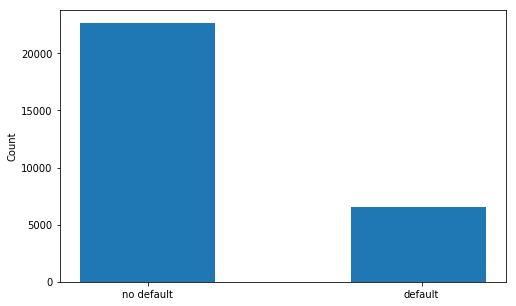

In [105]:
plt.figure(figsize = (8,5))
plt.hist(ccdf2['default'], bins = 3 , align = 'left');
plt.xticks([0,.675], ['no default', 'default']);
plt.ylabel('Count');

In [108]:
#Obvoisuly there is a little bit of an imbalance in our classes.  To remedy this we will try both oversampling and
# undersampling methods.
from sklearn.utils import resample

In [113]:
# Separate majority and minority classes
df_majority = ccdf2[ccdf2.default==0]
df_minority = ccdf2[ccdf2.default==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.default.value_counts()

1    22649
0    22649
Name: default, dtype: int64

In [114]:
df_upsampled.to_pickle('ccdf_upsampled.pkl')

In [116]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.default.value_counts()

1    6514
0    6514
Name: default, dtype: int64

In [117]:
df_downsampled.to_pickle('ccdf_downsampled.pkl')

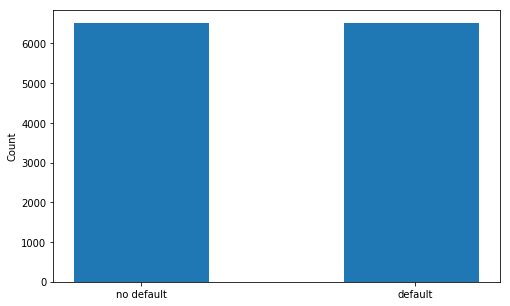

In [118]:
plt.figure(figsize = (8,5))
plt.hist(df_downsampled['default'], bins = 3 , align = 'left');
plt.xticks([0,.675], ['no default', 'default']);
plt.ylabel('Count');

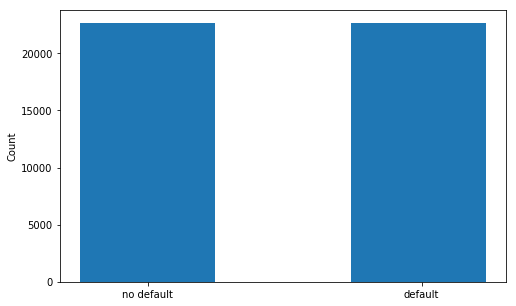

In [119]:
plt.figure(figsize = (8,5))
plt.hist(df_upsampled['default'], bins = 3 , align = 'left');
plt.xticks([0,.675], ['no default', 'default']);
plt.ylabel('Count');